## Setup

Load Libraries

In [30]:
import os
import re
import time
import random
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Optional, List, Tuple

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# see https://spacy.io/usage for proper spacy installation
import spacy
from spacy.lang.en import STOP_WORDS

nlp = spacy.load('en_core_web_sm')  # load text processing pipeline from spacy

## Data

The data we will use can be found [here](https://cogcomp.seas.upenn.edu/Data/QA/QC/). The dataset comprises three variables: `question`, `category`, and `sub-category`. However, our analysis will only use two variables: `question` and `category`. Essentially, we will build a model that uses the content of the question to predict its category. For example, (e.g. Who was Abraham Lincon?) and the output or label would be Human. There are six disnnct categories in the dataset:

1. ENTY (Entity): Questions that seek specific entities as answers, like objects, organisms, or concepts.
2. HUM (Human): Questions about humans, individually or as a group.
3. DESC (Description): Questions asking for description, explanations, or reasons.
4. Num (Numeric): Questions expecting numerical answer.
4. LOC (Locanon): Questions that are geographically oriented.
6. ABBR (Abbreviation): Questions seeking the extended form or explanation of abbreviations.

For this work, we will use the Training Set 5 dataset for training the model and the single test set available for testing the model.

We will now create the data download utility function.

In [11]:
dir_name = './data'
os.makedirs(dir_name, exist_ok=True)

In [12]:
def download_data(dir_name: str, filename: str, url: str, expected_bytes: Optional[int]=None) -> str:
    """
    Download a file if not present, and make sure it's the right size if the expected size is provided.
    
    Args:
        dir_name (str): The directory where the data will be stored.
        filename (str): The filename under which the data will be stored.
        url (str): The URL from which to download the data.
        expected_bytes (Optional[int]): The expected size of the data in bytes. 
                                        If provided, the function will check if the downloaded file size matches this.
                                        If not, an exception will be raised.
                                        If not provided, no size check will be performed.
                                        
    Returns:
        str: The file path where the data is stored.
    """
    
    
    # Define the filepath
    filepath = os.path.join(dir_name, filename)

    # Download the file if it doesn't already exist
    if not os.path.exists(filepath):
        response = requests.get(url)
        with open(filepath, 'wb') as f:
            # Write the content of the response to filepath
            f.write(response.content)

    # If an expected size is provided, verify the size of the downloaded file
    if expected_bytes is not None:   
        statinfo = os.stat(filepath)
        if statinfo.st_size == expected_bytes:
            print(f'Found and verified {filepath}')
        else:
            print(f'File size {statinfo.st_size} does not match expected size {expected_bytes}')
            raise Exception(
              f'Failed to verify {filepath}. Can you get to it with a browser?')
    
    # Return the filepath for use elsewhere
    return filepath


In [13]:
# Download the data.
url = 'http://cogcomp.org/Data/QA/QC/'
dir_name = 'data'
train_filename = download_data(dir_name, 'train_5500.label', url+'train_5500.label', 335858)
test_filename = download_data(dir_name, 'TREC_10.label', url+'TREC_10.label', 23354)

Found and verified data/train_5500.label
Found and verified data/TREC_10.label


## Load Data

In [14]:
def read_data(filename: str) -> Tuple[List[str], List[str], List[str]]:
    """
    Read data from a file with given filename.

    Returns:
        Tuple containing three lists of strings representing questions, categories, and sub-categories, respectively.
    """
    
    questions, categories, sub_categories = [], [], []
    
    try:
        with open(filename,'r',encoding='latin-1') as f:        
            for row in f:
                # Check if the row can be split into category and sub_category+question
                if ':' in row:
                    cat, sub_cat_and_question = row.split(":", 1)
                    tokens = sub_cat_and_question.split(' ')
                    sub_cat, question = tokens[0], ' '.join(tokens[1:])
                    
                    questions.append(question.strip())
                    categories.append(cat)
                    sub_categories.append(sub_cat)
                else:
                    print(f"Skipping invalid row: {row}")
                    
    except FileNotFoundError:
        print(f"The file {filename} was not found.")
        
    return questions, categories, sub_categories

## Let's inspect Sample data

In [15]:
def print_samples(questions: List[str], categories: List[str], sub_categories: List[str], n_samples: int):
    """
    Print samples from the questions, categories, and sub_categories lists.

    Args:
        questions: A list of questions.
        categories: A list of categories corresponding to the questions.
        sub_categories: A list of sub_categories corresponding to the questions.
        n_samples: The number of samples to print.
    """
    
    print(f"Data has {len(questions)} questions and {len(categories)} labels")
    print("Sample Observations:")
    for question, cat, sub_cat in zip(questions[:n_samples], categories[:n_samples], sub_categories[:n_samples]):
        print(f"\tQuestion - {question} / Category - {cat} / Sub-category - {sub_cat}")

train_questions, train_categories, train_sub_categories = read_data(train_filename)
test_questions, test_categories, test_sub_categories = read_data(test_filename)

n_samples = 5
print("Train Data:")
print("===========")
print_samples(train_questions, train_categories, train_sub_categories, n_samples)
print('\n')
print("Test Data:")
print("==========")
print_samples(test_questions, test_categories, test_sub_categories, n_samples)

Train Data:
Data has 5452 questions and 5452 labels
Sample Observations:
	Question - How did serfdom develop in and then leave Russia ? / Category - DESC / Sub-category - manner
	Question - What films featured the character Popeye Doyle ? / Category - ENTY / Sub-category - cremat
	Question - How can I find a list of celebrities ' real names ? / Category - DESC / Sub-category - manner
	Question - What fowl grabs the spotlight after the Chinese Year of the Monkey ? / Category - ENTY / Sub-category - animal
	Question - What is the full form of .com ? / Category - ABBR / Sub-category - exp


Test Data:
Data has 500 questions and 500 labels
Sample Observations:
	Question - How far is it from Denver to Aspen ? / Category - NUM / Sub-category - dist
	Question - What county is Modesto , California in ? / Category - LOC / Sub-category - city
	Question - Who was Galileo ? / Category - HUM / Sub-category - desc
	Question - What is an atom ? / Category - DESC / Sub-category - def
	Question - When 

## Convert Trand and Test Data to Pandas Dataframe

In [16]:
# Create train and test data

train_data = pd.DataFrame({
    'question': train_questions, 
    'category': train_categories, 
    'sub_category': train_sub_categories
})

test_data = pd.DataFrame({
    'question': test_questions, 
    'category': test_categories,
    'sub_category': test_sub_categories
})

train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452 entries, 0 to 5451
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question      5452 non-null   object
 1   category      5452 non-null   object
 2   sub_category  5452 non-null   object
dtypes: object(3)
memory usage: 127.9+ KB


,question,category,sub_category
0,How did serfdom develop in and then leave Russ...,DESC,manner
1,What films featured the character Popeye Doyle ?,ENTY,cremat
2,How can I find a list of celebrities ' real na...,DESC,manner
3,What fowl grabs the spotlight after the Chines...,ENTY,animal
4,What is the full form of .com ?,ABBR,exp


## Initial Data Exploration


Let's create a function to clean our data before exploration. See the docstring for details.

In [17]:
def lemmatizer(text: str) -> List[str]:
    """Performs lemmatization on a text."""
    return [word.lemma_ for word in nlp(text)]

## get stop words
stop_words = ENGLISH_STOP_WORDS.union(STOP_WORDS)
stop_words = {words.replace("'", "") for words in stop_words}

def clean_questions(question: str) -> str:
    """
    Cleans up a question.

    - Replaces all new lines (\n) with white space.
    - Converts all words to lower case.
    - Removes all characters except a-z, A-Z, hyphens and white space.
    - Removes hyphens that are not part of a word.
    - Removes extra white spaces.
    - Removes stop words.
    - Performs lemmatization.
    """
    question = question.replace('\n', ' ').lower()  # replace newlines and convert to lowercase
    question = re.sub('[^-a-z ]', '', question)  # keep only letters, hyphens, and white space
    question = re.sub('(?<=[^a-z])-(?=[^a-z])', '', question)  # remove hyphens not part of a word
    question = re.sub(' +', ' ', question)  # replace multiple spaces with a single space
    question = ' '.join([word for word in question.split() if word not in stop_words])  # remove stop words
    question = lemmatizer(question)  # lemmatization
    return ' '.join(question)

In [22]:
start_time = time.time()
train_data.loc[:, 'cleaned'] = train_data.loc[:, 'question'].apply(clean_questions) 
print('Total time taken (mins): {:.2f} '.format(float(time.time()-start_time)/60))

Total time taken (mins): 0.38 


* Let's compare our data cleaning result with the original text.

In [25]:
# Get the total number of questions
num_questions = train_data.shape[0]

# Define the number of samples you want to compare
num_samples = 3

# Randomly select unique indices
indices_to_compare = random.sample(range(num_questions), num_samples)


# Loop over indices and print original and cleaned text, along with their category
for index in indices_to_compare:
    original_text = train_data.question[index]
    cleaned_text = train_data.cleaned[index]
    category = train_data.category[index]

    print(f'Training Sample Number: {index}'
          f'\nOriginal: {original_text}'
          f'\nCleaned: {cleaned_text}'
          f'\nCategory: {category}\n')

Training Sample Number: 4119
Original: Who created Harry Lime ?
Cleaned: create harry lime
Category: HUM

Training Sample Number: 2935
Original: What is the origin of the word `` mushroom '' ?
Cleaned: origin word mushroom
Category: DESC

Training Sample Number: 82
Original: What is the origin of head lice ?
Cleaned: origin head lice
Category: DESC



Our data cleaning step was successful, all stop were removed, all letter convertd to lower case, and so on. Next, we will view the label distribution.

In [26]:
print(f'Training Data Characteristics:\n=============================='
      f'\nTotal questions: {train_data.shape[0]}'
      f'\nTotal Entity Questions: {train_data["category"].value_counts().loc["ENTY"]}'
      f'\nTotal Hunman Being Questions: {train_data["category"].value_counts().loc["HUM"]}'
      f'\nTotal Description Questions: {train_data["category"].value_counts().loc["DESC"]}'
      f'\nTotal Numeric Questions: {train_data["category"].value_counts().loc["NUM"]}'
      f'\nTotal Location Questions: {train_data["category"].value_counts().loc["LOC"]}'
      f'\nTotal Abbreviation Questions: {train_data["category"].value_counts().loc["ABBR"]}')

Training Data Characteristics:
Total questions: 5452
Total Entity Questions: 1250
Total Hunman Being Questions: 1223
Total Description Questions: 1162
Total Numeric Questions: 896
Total Location Questions: 835
Total Abbreviation Questions: 86


* Some Visualizations

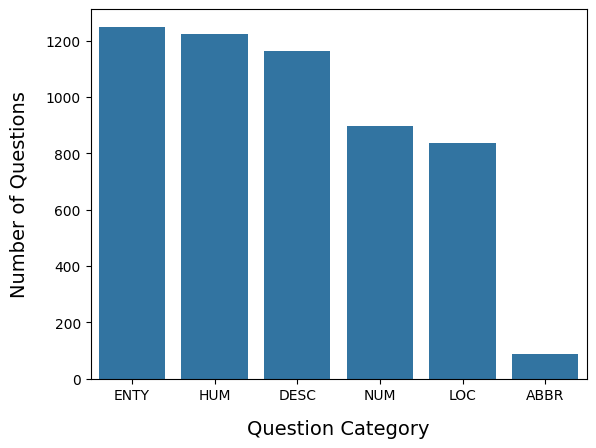

In [37]:
sns.countplot(x='category', data=train_data, order=train_data['category'].value_counts().index)
plt.ylabel("Number of Questions", labelpad=12, fontsize=14)
plt.xlabel("Question Category", labelpad=12, fontsize=14)
plt.show()

* Let's check word statistics

In [38]:
train_data['wordlengths'] = train_data["question"].str.split(" ").str.len()
train_data.wordlengths.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count    5452.000000
mean       10.204512
std         3.888865
min         3.000000
1%          4.000000
25%         7.000000
50%        10.000000
75%        12.000000
99%        22.000000
max        37.000000
Name: wordlengths, dtype: float64

In [39]:
test_data['wordlengths'] = test_data["question"].str.split(" ").str.len()
test_data.wordlengths.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count    500.000000
mean       7.516000
std        2.732889
min        4.000000
1%         4.000000
25%        5.000000
50%        7.000000
75%        9.000000
99%       15.010000
max       17.000000
Name: wordlengths, dtype: float64

- **Overall Distribution:** The mean word count for the training data stands at 10.2 words per quesnon, which indicates that on average, quesions in the training set are moderately long. This contrasts with the test data, which has a slightly shorter mean length of 7.5 words.

- **Variability:** The standard deviation, a measure of the amount of variation or dispersion of the word counts, is 3.89 for the training data and 2.73 for the test data. This suggests that the word counts of quesions in the training set are more spread out from the mean compared to those in the test set.

- **Word Count Range:** The range of word counts in the training set spans from a minimum of 3 words to a maximum of 37 words. This indicates a diverse set of quesions, from very concise to relanvely lengthy. The test data, on the other hand, contains quesions ranging from 4 to 17 words, suggesnng that it might lack the longer quesions seen in the training set.

The distribution of word length is plotted below.

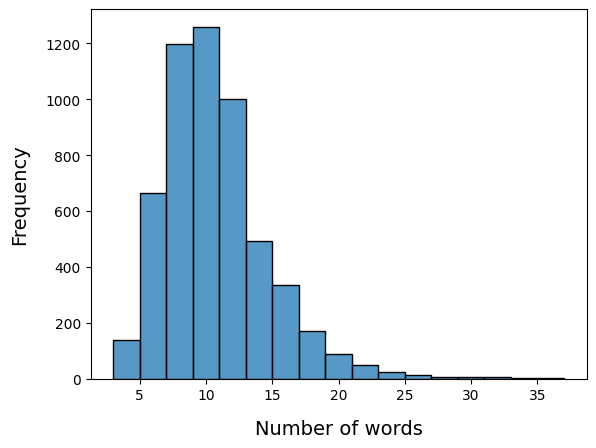

In [40]:
sns.histplot(x = 'wordlengths', data=train_data, binwidth=2)
plt.ylabel("Frequency", labelpad=12, fontsize=14)
plt.xlabel("Number of words", labelpad=12, fontsize=14)
plt.show()